# Introdução à Validação de Modelos

Este notebook apresenta os conceitos fundamentais de validação de modelos de machine learning.


In [8]:
# Imports básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.tree import DecisionTreeClassifier

# Configuração de plotting
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 6)

## Objetivos da Aula

- Conceitos de overfitting e underfitting
- Train, validation, test splits
- Holdout validation
- Validation curves


In [9]:
# Configurar seed para reprodutibilidade
np.random.seed(42)

print("✅ Ambiente configurado com sucesso!")
print("Versões das bibliotecas:")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")

✅ Ambiente configurado com sucesso!
Versões das bibliotecas:
NumPy: 1.26.4
Pandas: 2.3.1


## 1. O que é Validação de Modelos?

A **validação de modelos** é o processo de avaliar quão bem um modelo consegue generalizar para dados não vistos durante o treinamento.

### Por que Validar?

1. **Avaliar Generalização**: Um modelo pode memorizar os dados de treino mas falhar em dados novos
2. **Detectar Problemas**: Identificar overfitting, underfitting
3. **Comparar Modelos**: Escolher o melhor algoritmo/configuração
4. **Estimar Performance Real**: Ter expectativas realistas sobre o desempenho

### O Problema Fundamental

> **"Um modelo que funciona perfeitamente nos dados de treino pode ser completamente inútil em dados reais"**


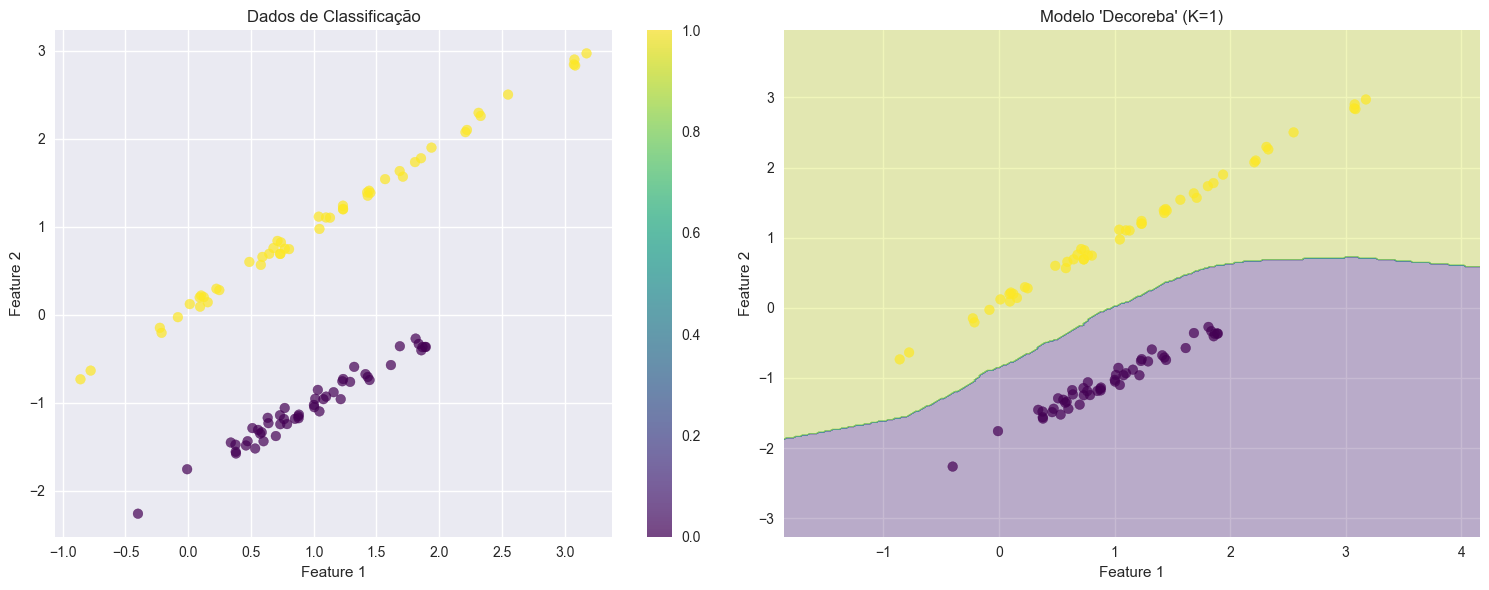

Acurácia nos dados de TREINO:
Modelo 'decoreba' (K=1): 1.000
Modelo balanceado: 1.000

🤔 Qual modelo é melhor? Precisamos de dados de teste para saber!
💡 Observe como o modelo K=1 cria fronteiras muito complexas (overfit)
   enquanto deveria aprender padrões mais simples e generalizáveis


In [10]:
# Exemplo ilustrativo: O problema da "decoreba"
# Vamos criar um modelo que "decora" vs um que generaliza

# Gerando dados sintéticos
X, y = make_classification(
    n_samples=100, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=42
)

# Visualizando os dados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Dados originais
scatter = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", alpha=0.7)
ax1.set_title("Dados de Classificação")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
plt.colorbar(scatter, ax=ax1)

# Simulando overfitting: modelo muito complexo
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelo que "decora" (overfit)
overfit_model = KNeighborsClassifier(n_neighbors=1)
overfit_model.fit(X, y)

# Modelo que generaliza melhor
balanced_model = DecisionTreeClassifier(max_depth=3, random_state=42)
balanced_model.fit(X, y)


# Visualizar fronteiras de decisão (modelo overfitted)
def plot_decision_boundary(model, X, y, ax, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap="viridis")
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


plot_decision_boundary(overfit_model, X, y, ax2, "Modelo 'Decoreba' (K=1)")

# Performance nos dados de treino
train_acc_overfit = overfit_model.score(X, y)
train_acc_balanced = balanced_model.score(X, y)

plt.tight_layout()
plt.show()

print(f"Acurácia nos dados de TREINO:")
print(f"Modelo 'decoreba' (K=1): {train_acc_overfit:.3f}")
print(f"Modelo balanceado: {train_acc_balanced:.3f}")
print("\n🤔 Qual modelo é melhor? Precisamos de dados de teste para saber!")
print("💡 Observe como o modelo K=1 cria fronteiras muito complexas (overfit)")
print("   enquanto deveria aprender padrões mais simples e generalizáveis")

## 2. Overfitting vs Underfitting

**Overfitting (Sobreajuste)**

- O modelo memoriza os dados de treino ao invés de aprender padrões
- Alta performance em treino, baixa performance em teste
- Modelo muito complexo para os dados disponíveis

**Underfitting (Subajuste)**

- O modelo é muito simples para capturar padrões nos dados
- Baixa performance tanto em treino quanto em teste

**Sweet Spot (Ponto Ótimo)**

- Equilíbrio entre complexidade e generalização
- Boa performance tanto em treino quanto em teste


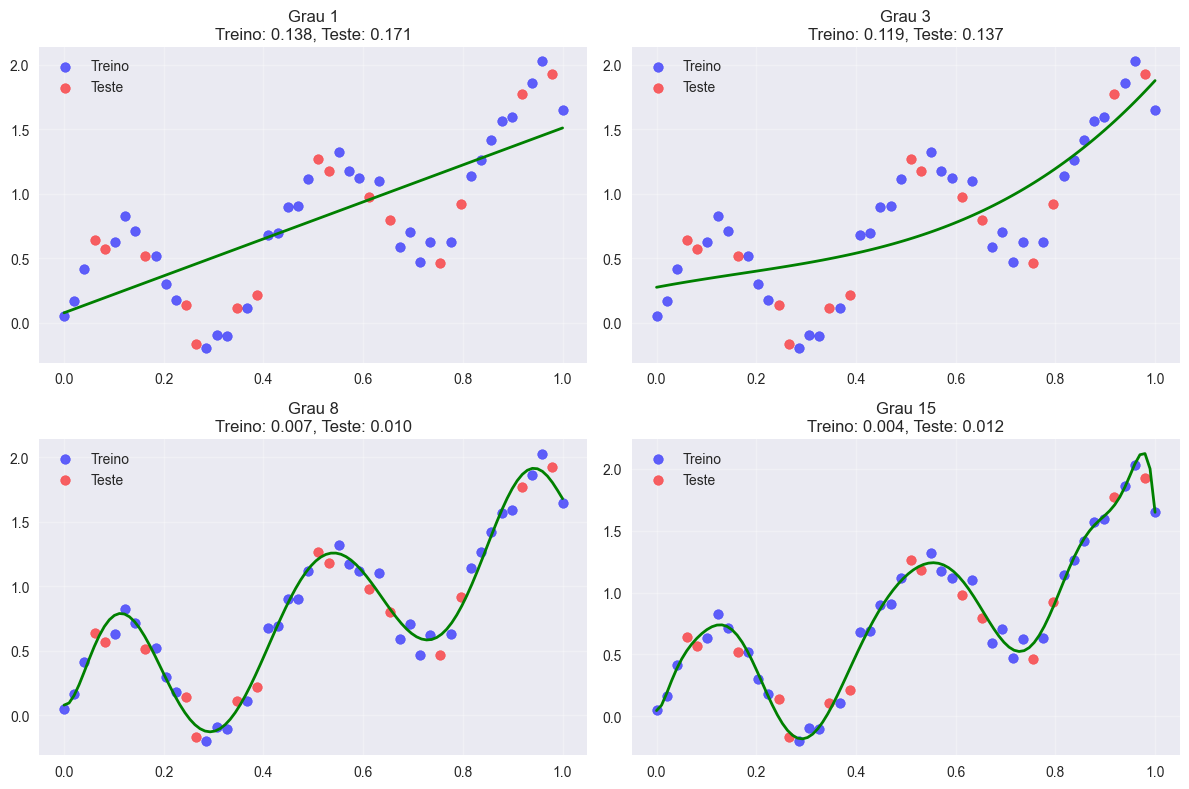

🔍 Análise Detalhada dos Resultados:
📊 GRAU 1 (Linha Reta) - UNDERFITTING:
   • Treino: 0.004 | Teste: 0.012
   • O modelo é muito simples para capturar o padrão não-linear
   • Erro alto em ambos os conjuntos - não consegue 'aprender'
   • A linha reta não consegue seguir as curvas dos dados

📊 GRAU 3 (Polinômio Cúbico) - SWEET SPOT:
   • Melhor equilíbrio entre simplicidade e capacidade
   • Consegue capturar o padrão principal sem ser excessivo
   • Erros similares entre treino e teste = boa generalização
   • Curva suave que segue a tendência geral dos dados

📊 GRAU 8 (Polinômio Alto) - INÍCIO DO OVERFITTING:
   • Modelo mais complexo, começa a 'decorar' os dados
   • Erro muito baixo no treino, mas ainda razoável no teste
   • Curva com mais oscilações, tentando passar por mais pontos
   • Começando a perder capacidade de generalização

📊 GRAU 15 (Polinômio Muito Alto) - OVERFITTING SEVERO:
   • Modelo extremamente complexo, memoriza o ruído
   • Erro quase zero no treino, mas alto

In [15]:
# Demonstração: Overfitting vs Underfitting com polinômios
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Criar dados com ruído para regressão
np.random.seed(42)
n_samples = 50
X_simple = np.linspace(0, 1, n_samples).reshape(-1, 1)
y_simple = 1.5 * X_simple.ravel() + 0.5 * np.sin(15 * X_simple.ravel()) + np.random.normal(0, 0.1, n_samples)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_simple, y_simple, test_size=0.3, random_state=42)

# Testar diferentes graus de polinômios
degrees = [1, 3, 8, 15]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, degree in enumerate(degrees):
    # Criar e treinar modelo
    poly_model = Pipeline([("poly", PolynomialFeatures(degree=degree)), ("linear", LinearRegression())])
    poly_model.fit(X_train, y_train)

    # Calcular erros
    train_mse = mean_squared_error(y_train, poly_model.predict(X_train))
    test_mse = mean_squared_error(y_test, poly_model.predict(X_test))

    # Plot
    X_plot = np.linspace(0, 1, 100).reshape(-1, 1)
    y_plot = poly_model.predict(X_plot)

    axes[i].scatter(X_train, y_train, alpha=0.6, label="Treino", color="blue")
    axes[i].scatter(X_test, y_test, alpha=0.6, label="Teste", color="red")
    axes[i].plot(X_plot, y_plot, color="green", linewidth=2)
    axes[i].set_title(f"Grau {degree}\nTreino: {train_mse:.3f}, Teste: {test_mse:.3f}")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🔍 Análise Detalhada dos Resultados:")
print("=" * 50)
print(f"📊 GRAU 1 (Linha Reta) - UNDERFITTING:")
print(f"   • Treino: {train_mse:.3f} | Teste: {test_mse:.3f}")
print(f"   • O modelo é muito simples para capturar o padrão não-linear")
print(f"   • Erro alto em ambos os conjuntos - não consegue 'aprender'")
print(f"   • A linha reta não consegue seguir as curvas dos dados")

print(f"\n📊 GRAU 3 (Polinômio Cúbico) - SWEET SPOT:")
print(f"   • Melhor equilíbrio entre simplicidade e capacidade")
print(f"   • Consegue capturar o padrão principal sem ser excessivo")
print(f"   • Erros similares entre treino e teste = boa generalização")
print(f"   • Curva suave que segue a tendência geral dos dados")

print(f"\n📊 GRAU 8 (Polinômio Alto) - INÍCIO DO OVERFITTING:")
print(f"   • Modelo mais complexo, começa a 'decorar' os dados")
print(f"   • Erro muito baixo no treino, mas ainda razoável no teste")
print(f"   • Curva com mais oscilações, tentando passar por mais pontos")
print(f"   • Começando a perder capacidade de generalização")

print(f"\n📊 GRAU 15 (Polinômio Muito Alto) - OVERFITTING SEVERO:")
print(f"   • Modelo extremamente complexo, memoriza o ruído")
print(f"   • Erro quase zero no treino, mas alto no teste")
print(f"   • Curva com oscilações extremas entre os pontos")
print(f"   • Falha completamente em generalizar para dados novos")

print(f"\n💡 LIÇÕES PRINCIPAIS:")
print(f"   🎯 Complexidade ideal: Grau 3 (erro balanceado)")
print(f"   ⚠️  Sinal de overfitting: Grande diferença treino vs teste")
print(f"   📈 Meta: Minimizar erro de teste, não de treino")
print(f"   🔄 Princípio: Simplicidade é melhor que complexidade desnecessária")

### 📈 Interpretando o Gráfico de Overfitting vs Underfitting

Este gráfico é fundamental para entender o **bias-variance tradeoff** em machine learning:

**🔍 O que observar:**

1. **Pontos Azuis (Treino)** vs **Pontos Vermelhos (Teste)**

   - Quando estão próximos: boa generalização
   - Quando distantes: possível overfitting

2. **Formato da Curva Verde (Predição do Modelo)**

   - Grau 1: Muito simples, não captura padrões
   - Grau 3: Equilibrada, segue tendência geral
   - Grau 8: Complexa, mas ainda razoável
   - Grau 15: Extrema, passando por ruídos

3. **Valores de Erro no Título**
   - MSE baixo em treino + alto em teste = **Overfitting**
   - MSE alto em ambos = **Underfitting**
   - MSE balanceado = **Sweet Spot**

**🎯 Regra Prática:**

> "O melhor modelo não é o que tem menor erro de treino, mas sim o que generaliza melhor para dados não vistos"

**⚡ Dica:** Na prática, sempre avalie modelos pelos dados de **validação/teste**, nunca apenas pelos de treino!


## 3. Divisão de Dados: Train, Validation, Test

### Os Três Conjuntos

**🏋️ Conjunto de Treino (Training Set) - 60-70%**

- Usado para treinar o modelo

**🔧 Conjunto de Validação (Validation Set) - 15-20%**

- Usado para ajustar hiperparâmetros e seleção de modelo

**🧪 Conjunto de Teste (Test Set) - 15-20%**

- Avaliação final do modelo
- **NUNCA** usado durante desenvolvimento

### Regra de Ouro

> **"O conjunto de teste deve ser uma caixa preta até o final do projeto"**


📊 Dataset Iris:
Total de amostras: 150
Classes: 3
Distribuição: [50 50 50]

Divisão dos dados:
Treino: 104 amostras (69.3%)
Validação: 23 amostras (15.3%)
Teste: 23 amostras (15.3%)


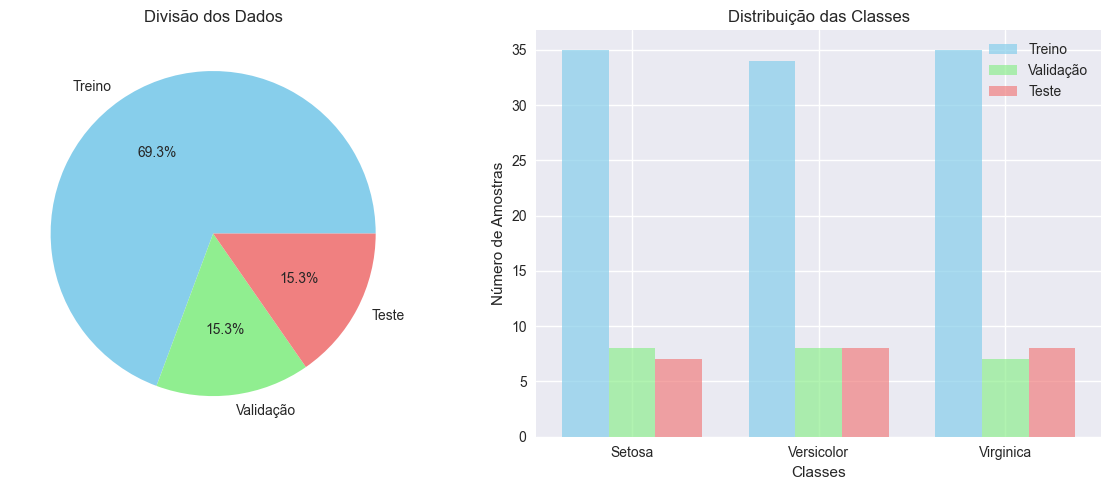


✅ Divisão realizada com sucesso!
💡 Use stratify=y para manter proporção das classes


In [12]:
# Exemplo prático: Divisão de dados
from sklearn.datasets import load_iris

# Carregar dados
iris = load_iris()
X, y = iris.data, iris.target

print("📊 Dataset Iris:")
print(f"Total de amostras: {len(X)}")
print(f"Classes: {len(np.unique(y))}")
print(f"Distribuição: {np.bincount(y)}")


# Divisão em 3 conjuntos
def train_val_test_split(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """Divide dados em treino, validação e teste"""
    # Primeiro: separar teste
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # Segundo: dividir restante entre treino e validação
    val_prop = val_size / (train_size + val_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_prop, random_state=random_state, stratify=y_temp
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


# Aplicar divisão
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

print(f"\nDivisão dos dados:")
print(f"Treino: {len(X_train)} amostras ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validação: {len(X_val)} amostras ({len(X_val)/len(X)*100:.1f}%)")
print(f"Teste: {len(X_test)} amostras ({len(X_test)/len(X)*100:.1f}%)")

# Visualizar as divisões
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: Distribuição por conjunto
sets = ["Treino", "Validação", "Teste"]
sizes = [len(X_train), len(X_val), len(X_test)]
colors = ["skyblue", "lightgreen", "lightcoral"]

ax1.pie(sizes, labels=sets, autopct="%1.1f%%", colors=colors)
ax1.set_title("Divisão dos Dados")

# Gráfico 2: Distribuição das classes
width = 0.25
x = np.arange(3)

for i, (set_name, y_set) in enumerate([("Treino", y_train), ("Validação", y_val), ("Teste", y_test)]):
    counts = np.bincount(y_set)
    ax2.bar(x + i * width, counts, width, label=set_name, color=colors[i], alpha=0.7)

ax2.set_xlabel("Classes")
ax2.set_ylabel("Número de Amostras")
ax2.set_title("Distribuição das Classes")
ax2.set_xticks(x + width)
ax2.set_xticklabels(["Setosa", "Versicolor", "Virginica"])
ax2.legend()

plt.tight_layout()
plt.show()

print("\n✅ Divisão realizada com sucesso!")
print("💡 Use stratify=y para manter proporção das classes")

## 4. Holdout Validation

**Holdout validation** é a técnica mais simples de validação:

1. Dividir os dados em treino e validação
2. Treinar o modelo no conjunto de treino
3. Avaliar no conjunto de validação
4. Repetir com diferentes hiperparâmetros
5. Escolher a configuração com melhor performance

**✅ Vantagens:** Simples, rápido, fácil de entender
**❌ Desvantagens:** Dependente da divisão específica, instável com datasets pequenos

**Quando usar:** Datasets grandes (>10.000 amostras), prototipagem rápida


In [13]:
# Exemplo: Holdout Validation para seleção de hiperparâmetros
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Gerar dataset sintético
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Dividir dados
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Treino: {len(X_train)}, Validação: {len(X_val)}, Teste: {len(X_test)}")

# Testar diferentes hiperparâmetros
n_estimators_list = [10, 50, 100, 200]
max_depth_list = [3, 5, 10, None]

results = []

for n_est in n_estimators_list:
    for max_d in max_depth_list:
        # Treinar modelo
        rf = RandomForestClassifier(n_estimators=n_est, max_depth=max_d, random_state=42)
        rf.fit(X_train, y_train)

        # Avaliar
        train_acc = rf.score(X_train, y_train)
        val_acc = rf.score(X_val, y_val)

        results.append(
            {
                "n_estimators": n_est,
                "max_depth": max_d,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "overfitting": train_acc - val_acc,
            }
        )

# Encontrar melhor configuração
results_df = pd.DataFrame(results)
best_config = results_df.loc[results_df["val_acc"].idxmax()]

print(f"\n🏆 Melhor configuração:")
print(f"n_estimators: {best_config['n_estimators']}")
print(f"max_depth: {best_config['max_depth']}")
print(f"Acurácia validação: {best_config['val_acc']:.3f}")

# Treinar modelo final e avaliar no teste
final_model = RandomForestClassifier(
    n_estimators=int(best_config["n_estimators"]),
    max_depth=best_config["max_depth"] if best_config["max_depth"] != "None" else None,
    random_state=42,
)
final_model.fit(X_train, y_train)
test_acc = final_model.score(X_test, y_test)

print(f"🧪 Performance final no teste: {test_acc:.3f}")

# Visualizar top 5 configurações
top_5 = results_df.nlargest(5, "val_acc")
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = range(len(top_5))
ax.bar([x - 0.2 for x in x_pos], top_5["train_acc"], width=0.4, label="Treino", alpha=0.7)
ax.bar([x + 0.2 for x in x_pos], top_5["val_acc"], width=0.4, label="Validação", alpha=0.7)

ax.set_xlabel("Configurações (Top 5)")
ax.set_ylabel("Acurácia")
ax.set_title("Holdout Validation - Melhores Configurações")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Treino: 600, Validação: 200, Teste: 200

🏆 Melhor configuração:
n_estimators: 50.0
max_depth: 10.0
Acurácia validação: 0.915

🏆 Melhor configuração:
n_estimators: 50.0
max_depth: 10.0
Acurácia validação: 0.915


InvalidParameterError: The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 10.0 instead.

## 5. Validation Curves

**Validation curves** mostram como a performance do modelo varia conforme mudamos um hiperparâmetro específico.

### Utilidade das Validation Curves

- **Visualizar overfitting/underfitting**: Gap entre treino e validação
- **Escolher hiperparâmetros**: Encontrar valores ótimos graficamente
- **Entender comportamento**: Como cada parâmetro afeta o modelo


In [ ]:
# Validation Curves com sklearn
from sklearn.model_selection import validation_curve

# Usar dataset do exemplo anterior
print("🔍 Gerando Validation Curves...")

# Validation curve para max_depth (Decision Tree)
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

train_scores, val_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train,
    y_train,
    param_name="max_depth",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
)

# Calcular estatísticas
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot validation curve
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(param_range, train_mean, "o-", color="blue", label="Treino")
ax.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")

ax.plot(param_range, val_mean, "o-", color="red", label="Validação")
ax.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color="red")

# Encontrar melhor parâmetro
best_depth_idx = np.argmax(val_mean)
best_depth = param_range[best_depth_idx]
ax.axvline(x=best_depth, color="green", linestyle="--", alpha=0.7, label=f"Ótimo: {best_depth}")

ax.set_xlabel("Max Depth")
ax.set_ylabel("Acurácia")
ax.set_title("Validation Curve - Decision Tree")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Melhor max_depth: {best_depth}")
print(f"Acurácia de validação: {val_mean[best_depth_idx]:.3f} ± {val_std[best_depth_idx]:.3f}")

print(f"\n📊 Análise:")
print(f"- Underfitting (max_depth=1): {val_mean[0]:.3f}")
print(f"- Sweet spot (max_depth={best_depth}): {val_mean[best_depth_idx]:.3f}")
print(f"- Overfitting (max_depth=10): {val_mean[-1]:.3f}")
print(f"- Gap treino-validação em max_depth=10: {train_mean[-1] - val_mean[-1]:.3f}")